In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset

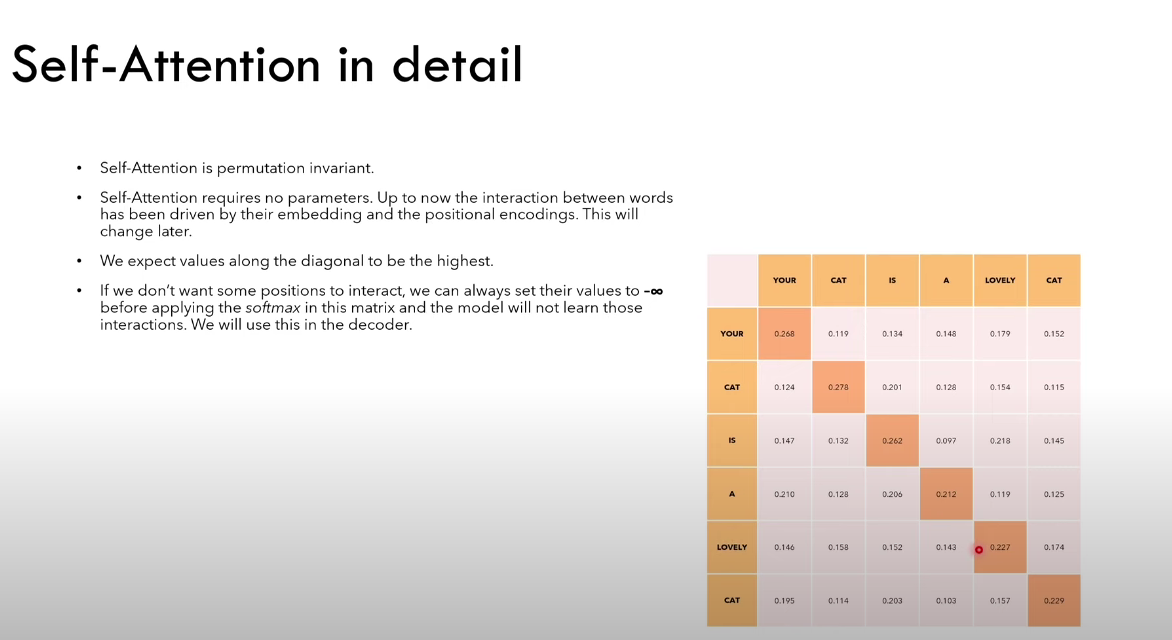

- we want each word in the decoder to only watch words that become before it so what we want is to make all these values Above This value.

 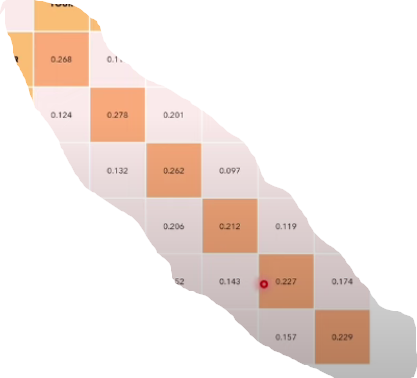

  Above This diagonal that represent this matrix represent the maltiplication of the matrix queries by the keys in the self attention machanism what we want is to hide all these values so you watch the word.
  
  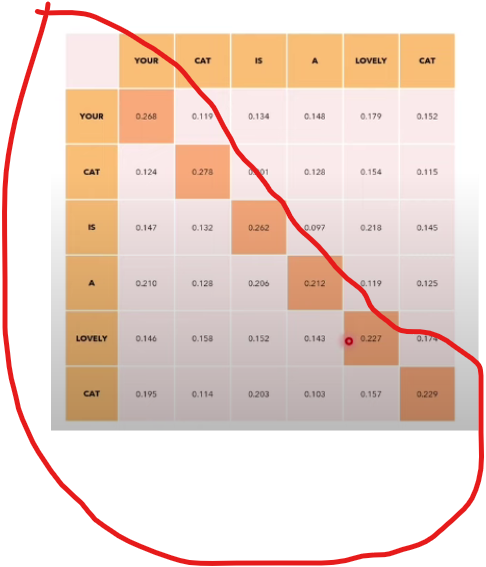

  for example - your cat is a lovely cat it can only watch itself but this word here lovely can watch everything that comes before it so from your up to lovely itself but not the word cat that comes after it

  - your hai jo your ko dekh sakta hai cat ko nahi dekh sakta, 
  - cat hai jo your or cat dono ko dekh sakta hai is ko nahi dekh sakta 
  - is ha jo your, cat, is tak dekh sakta hai a ko nahi dekh sakta 
  
  
  
  
  so what we do is we want all these values heare to be masked out 


```
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

```

In [2]:
class BilingualDataset(Dataset):
    
    def __init__(self,
                 ds,                     # dataset define the huggingface
                 tokenizer_src,          # tokenizer of the source language
                 tokenizer_tgt,          # tokenizer of the target language 
                 src_lang,               # name of the source language 
                 tgt_lang,               # name of the target language 
                 seq_len                 # sequence length we will used 
                 ) -> None: 
        super().__init__()
        
        self.seq_len = seq_len
        self.ds = ds 
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt 
        self.src_lang = src_lang 
        self.tgt_lang = tgt_lang 
        
        
        # we can also save the tokens the particular tokens that we will use to creat the tensor for the model 
        # so we need start of the sentence and end of the sentence and padding token 
        # so how do we convert the token start of sentence into a number into the input ID there is the special method of the tokenizer to do that so let's do it 
        self.sos_token = torch.tensor([tokenizer_tgt.           # so this is the start of sentence token we want to build it into a tensor this tensor will contain only one number which is given by we can use this tokenizer from the source or the target it does not matter because they both contain these particular tokens 
                                       token_to_id("[SOS]")],   # this is the method to convert into the token into the number start sentence and type for this token of this tensor is 
                                      dtype=torch.int64)        # we want it long because the vocabulary can be more than 32 bit long this vocabulary size, so we usually use the long 64-bit 
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)    # End of the sentence 
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)     # padding token 
        
        
        
     # we also need to define the length method of this dataset    
    def __len__(self):
        return len(self.ds)    # length of the dataset from the hugging phase 
    
    
   
    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]   # first of all we will extract the original pair from the hugging phase dataset
        src_text = src_target_pair['translation'][self.src_lang]   #  then we extract the source text and the target text 
        tgt_text = src_target_pair['translation'][self.tgt_lang]
        
        
        # Transform the text into tokens 
        # finally we convert each text into a token and then into input IDs what does it mean we will first the tokenizer will first split the sentence into single words 
        # and then we will map each word into its corresponding number in the vocabulary and it will do it in one path only 
        enc_input_tokens =    # this is encoder input token
        self.tokenizer_src.encoder(src_text).ids    # this gives us the inputs IDs so the numbers corresponding to each word into the original sentence and it will be given as an array 
        dec_input_tokens = self.tokenizer_tgt.encoder(tgt_text).ids 
        
        
        
        
        
        # Add sos, eos and padding to each sentence 
        # we also need to padding the sentence to reach the sequence length this is really important because we want our model to always work i mean the model always with a fixed length sequence length but we don't have enough words in every sentence so 
        # we use the padding token to fill the sentence until it reaches the sequence length 
        # so we calculate how may padding toolkeys we need to add for the encoder and decoder size 
        enc_num_padding_tokens = 
        self.seq_len      # how many we need to reach the sequence length
        - len(enc_input_tokens) - 2   # why -2 heare so we already have this amount of token we need to reach this one but we will add also the starts of sentence token and the end of sentence token to this to the encoder side so we have -2 here 
        # we will only add <s> and </s> only on the label 
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1   # here are -1 because when we do the training we add only the start of sentence token to the decoder side and then in the label we only add the end of sentence token so in this case we only need to add one token special token into the sentence 
        
        
        # Make sure the number of padding tokens is not negative. If it is the sentence is too long 
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")
        
        
        
        # Add <s> and </s>
         # let's build the two tensors for the encoder input and for the decoder input but also for the label so one sentence will be sent to the input of the encoder and one sentence will be sent to the input of the deocder 
         # and sentence is to one that we expactas the output of the decoder and that output we will call label usually its called target or label but i call it label 
        encoder_input = torch.cat([       # we concate three tensor 
            self.sos_token,               # first is the start of the sentence token 
            torch.tensor(enc_input_tokens, dtype=torch.input64),      # and then token of the sourc text 
            self.eos_token,                                           # end of the sentence token 
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64)     # and then enough padding tokens to reach the sequence length we already calculated how many embedding tokens we need to add to this sentence 
        ],
        dim=0,
        )
        
        
        # Add only <s> token 
        # in the decoder input add the only start of sentence token 
        decoder_input = torch.cat(
            [
                self.sos_token, 
                torch.tensor(dec_input_tokens, dtype = torch.input64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64),
            ],
            dim=0,
        )
        
        
        # Add only </s> token 
        # in the label we just add the end of sentence token 
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.input64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim = 0
        )
        
        
        # Doble check the size of the tensors to make sure they are all seq_len long 
        # so we are dobule check that we actually reached this sequence legth or not 
        assert encoder_input.size(0) == self.seq_len 
        assert decoder_input.size(0) == self.seq_len 
        assert label.size(0)  == self.seq_len
        
        
        
        # so now we can reaturn all these tensor so that our training can use them 
        
        return {
            "encoder_input": encoder_input,  #(seq_len)
            "decoder_input":decoder_input,    # (seq_len) number of tokens 
             # (1, 1, seq_len), as you remember we are increasing the size of the encoder input sentence by adding padding tokens but we don't want these padding tokens to participate in the self-attention so what we need is build a mask that we don't want these tokens to be seed by the self-attention mechanism and so we built the mask for the encoder 
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).int(),     # how to we build this mask we just say that all the tokens that are not padding okey all tokens that are padding and add the unsqueeze to add thie sequence dimension and also add the batch dimension later and we convert into integer 
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & 
            causal_mask(decoder_input.size(0)),   # (1, seq_len) & (1, seq_len, seq_len)   # this causal mask need to build to matrix of size sequence length to sequence length -> is basically the size of our decoder input 
            "label":label, 
            "src_text":src_text,     # source text 
            "tgt_text":tgt_text,     # target text 
            
            
        }
        
        
 # in the decoder we use the special mask that is causal mask which means that each  word can only look at the previous words and each word can only look at not known padding words so we don't want the padding tokens to participate in the self-attention we only want real words to participate in this and we also don't want each word to watch at words that come after  it but only that words come before  it so i will use a method here        
 
        
def causal_mask(size):
    # this will return all the values above the dignoal and everything below the dignoal will become zero but we want actually the oposite so we say okey
    mask = torch.triu(     # which means give me the every value that is above the digonal 
        torch.ones(       # we want matrix which matrix, Matrix makd of all ones 
            (1, size, size)),   # and this method will return every value above the digonal and everythings else will become zero 
        diagonal=1)
    .type(torch.int)  # and the type is integer 
    
    return mask == 0     # that is zero should will become true with this expression and everything that is not zero will become false 
        
        
        
        
        
        